# Electricity Demand Analysis

In [1]:
%load_ext autoreload
%autoreload 2

# Standard Python
import os
import pandas as pd
import matplotlib.pyplot as plt

# NEM-TEL modules
from nemtel.tracker import NEM_tracker
from nemtel.extractor import NEM_extractor
from nemtel.loader import NEM_loader

# Configuration
import config
config.use('config.json')

Value for DATA_PATH has been set!


## NEM-TEL: Track, Extract, Load
***
### Resource Tracking

In [3]:
data_dir = os.getenv('DATA_PATH')
#nem_trk = NEM_tracker(data_dir)
#nem_trk.bulk_update()

### Resource Extraction

In [4]:
nem_get = NEM_extractor(data_dir)
nem_get.load_tracker_df()
nem_get.set_download_df(by_time_range=True)
nem_get.download_df

[0] /Reports/Current/Operational_Demand/ACTUAL_DAILY/
[1] /Reports/Current/Dispatch_SCADA/
[2] /Reports/Current/Next_Day_Intermittent_DS/
[3] /Reports/Archive/Operational_Demand/Actual_Daily/

Selected: /Reports/Archive/Operational_Demand/Actual_Daily/


,TIMESTAMP,VERSION,DOWNLOADED,DOWNLOAD_DATE,URL
0,2019-02-01,Archive,False,1900-01-01,http://nemweb.com.au/Reports/Archive/Operation...
1,2019-03-01,Archive,False,1900-01-01,http://nemweb.com.au/Reports/Archive/Operation...
2,2019-04-01,Archive,False,1900-01-01,http://nemweb.com.au/Reports/Archive/Operation...
3,2019-05-01,Archive,False,1900-01-01,http://nemweb.com.au/Reports/Archive/Operation...
4,2019-06-01,Archive,False,1900-01-01,http://nemweb.com.au/Reports/Archive/Operation...
5,2019-07-01,Archive,False,1900-01-01,http://nemweb.com.au/Reports/Archive/Operation...
6,2019-08-01,Archive,False,1900-01-01,http://nemweb.com.au/Reports/Archive/Operation...
7,2019-09-01,Archive,False,1900-01-01,http://nemweb.com.au/Reports/Archive/Operation...


In [5]:
nem_get.download_files()

### Resource Loader

In [6]:
nem_load = NEM_loader(data_dir)
res_dict = dict(enumerate(nem_load.resources.keys()))
res_dict

{0: '/Reports/Current/Operational_Demand/ACTUAL_DAILY/',
 1: '/Reports/Current/Dispatch_SCADA/',
 2: '/Reports/Current/Next_Day_Intermittent_DS/',
 3: '/Reports/Archive/Operational_Demand/Actual_Daily/'}

In [8]:
data = {}
for i in [0, 3]:
    nem_load.select_resource (res_dict[i])
    nem_load.get_available_files()
    nem_load.set_read_list(all_files=True)
    data.update(nem_load.process_read_list())

## Analysis
***
### Pre-processing

In [18]:
demand_df = pd.concat([v[0] for v in data.values()])
demand_df = demand_df[['INTERVAL_DATETIME','REGIONID','OPERATIONAL_DEMAND.1']]
demand_df.columns = ['TIMESTAMP','STATE','DEMAND']
demand_df.loc[:, 'TIMESTAMP'] = pd.to_datetime(demand_df['TIMESTAMP'])
demand_df = demand_df.sort_values(by=['STATE', 'TIMESTAMP'])
demand_df.head()

,TIMESTAMP,STATE,DEMAND
0,2019-02-01 04:30:00,NSW1,6976
1,2019-02-01 05:00:00,NSW1,7213
2,2019-02-01 05:30:00,NSW1,7653
3,2019-02-01 06:00:00,NSW1,8013
4,2019-02-01 06:30:00,NSW1,8369


### Basic visual

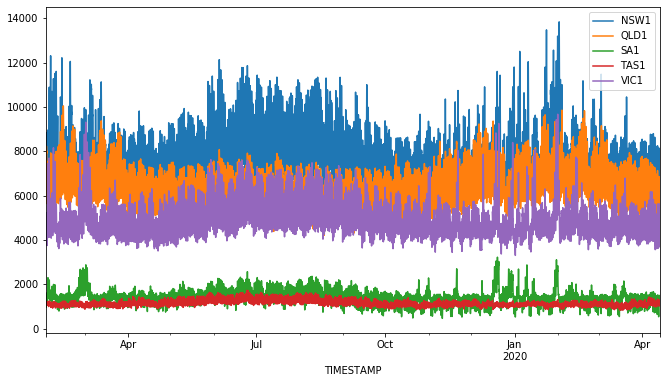

In [25]:
grp_df = demand_df.set_index('TIMESTAMP').groupby('STATE')['DEMAND']
grp_df.plot(legend=True, figsize=(11,6))
plt.show()